[View in Colaboratory](https://colab.research.google.com/github/jgarci135/Practicum-I/blob/master/Med_transfer_(2)_(1).ipynb)

# Classification of Medical image files
##Company interest project
**Description of data:**
The images were obtained from video of medical procedures.  Due to the nature of the images and the current development within the company the images and the specific objective cannot be shared and is protected by an NDA.  There is an interest in specific features that occur at a specific time point.  The images collected are roughly collected from the same time point and have 5 different classifications present.  The classifications will be labeled simply 0,1,2,3,4+ or labeled with a PN prefix.  This is a limited data set as there is only 3732 samples present.  

**Objective:**
The objective of this project is to accurately identify the 5 classifications with good accuracy.  This data set is a good candidate for use with transfer learning.  There are not enough samples for a convolution neural network to properly learn the defining features and will benefit from the use of models that have been trained on much larger data sets.

##1. Set up to use Google Colab with Google Drive
The following cells contain how to set up a mounted drive to pull data from Google Drive. This is necessary as the VM instance of the Colab is reset at any point and all variables that are uploaded to the Colab will be erased. This helps then so that large image data sets do not need to be reloaded with each use.  Colab use is restricted to roughly 12 hours or GPU use and thus setting up the data set on a cloud is necessary.

In [61]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

gpg: keybox '/tmp/tmp9mk76uzp/pubring.gpg' created
gpg: /tmp/tmp9mk76uzp/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [3]:
#@title Default title text
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
# Create a folder to use the competition
!mkdir -p /content/drive/practicum/

**Install tqdm dependancy. **

Many of the files needed are preinstalled in Google Colab however this one is not at this time and needs to be installed for use.

In [5]:
#Install tqdm for use with GoogleColab
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.7MB/s 


##Load Libraries

In [0]:
import sys
import keras
import tensorflow as tf
import numpy as np
import tqdm
import itertools
import argparse
import cv2
import os, shutil
import random
import h5py
import matplotlib as mpl
import seaborn as sns
import pandas as pd
from IPython.display import Image
from os import path
from matplotlib import pyplot as plt
%matplotlib inline
from PIL import Image
from PIL import ImageOps
from collections import Counter
from glob import glob


from keras import backend as K

from keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping

from keras.optimizers import SGD, Adam, RMSprop

from keras.models import Model
from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import MobileNet
from keras.applications import VGG19
from keras.applications import imagenet_utils


from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from skimage import data, img_as_float
from skimage import exposure
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

config = tf.ConfigProto()
sess = tf.Session(config=config)
keras.backend.set_session(sess)


##2. Image Processing and Preparation
Set up training and validation data splits.  The data does not have a file for labels but can be infered from the folder structure.  The file structure will also be important later on because data generators will be used to call the images.  Because the data set was small 90% was kept for training and 10% is to be used for validation. 

PN Check train -                 
       |
          ---0         
       |
          ---1
       |
          ---2
       |
          ---3
       |
          ---4
          
PN Check Val -                 
       |
          ---0         
       |
          ---1
       |
          ---2
       |
          ---3
       |
          ---4
          
**Croping, resizing, and normalizing images**

Images were also cropped and resized to 224x 224. The cropping of the images is important as there is no data contained in the outer edges of the images.  The resize will also help fit the application with a couple different pretrained model requirements which saves time.  If needed the images can also be normalized at this point.  In my application the images were left in RGB and normalized.  I also tried adaptive histogram equalization.  The histogram equalization accentuates the image lines where as the normalization brings all pixel values between a range of 0-1.

In [0]:
# split data into train and val
#data_dir = os.path.join('../content/drive/practicum/pn_check_formated')#CoLab
data_dir = os.path.join('/home/joshua/Downloads/pn_check_formated')#HomeSystem
num_classes = len(glob(data_dir + "/*"))

train_dir = "pn_check_train"
val_dir = "pn_check_val"

shutil.rmtree(train_dir, ignore_errors=True)
shutil.rmtree(val_dir, ignore_errors=True)
os.makedirs(train_dir)
os.makedirs(val_dir)

# Crop images 
tf_images = tf.placeholder(tf.uint8, shape=(None, None, None, 3))
unet_pb = "unet_s64_d2_ch32_2018-02-16.pb"
with tf.gfile.FastGFile(unet_pb, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    node_map = dict([(n.name, n) for n in graph_def.node])
    
    g_in = tf.import_graph_def(graph_def, 
                               name="keras_image_cropper",
                               input_map={"keras_image_cropper/image_input:0": tf_images},
                               return_elements=["keras_image_cropper/cropped_image:0", 
                                                "keras_image_cropper/crop_mask:0"])
    
def cropImage(image):
    cropped_images, crop_mask = sess.run(g_in, feed_dict={tf_images:np.expand_dims(image, axis=0)})
    return cropped_images[0]

for class_folder in tqdm.tqdm_notebook(glob(data_dir + "/*")):
    class_name = os.path.basename(class_folder)
    files = glob(class_folder + "/*.jpg")
    random.shuffle(files)
    split = int(len(files) * 0.9)
    os.makedirs(os.path.join(train_dir, class_name))
    os.makedirs(os.path.join(val_dir, class_name))
    for file in tqdm.tqdm_notebook(files[:split]):
        img = np.array(Image.open(file), np.float32) 
        crop_img = cropImage(img) * 255.0
        crop_img = crop_img.astype(np.byte)
        dst = np.zeros(shape=(224,224))       
        # Rotate images
        if img.shape[0] > 500: 
            crop_img = np.rot90(crop_img, -1)
            
        Image.fromarray(crop_img, "RGB").save(os.path.join(train_dir, class_name, os.path.basename(file)))
        image = cv2.imread((os.path.join(train_dir, class_name, os.path.basename(file))), cv2.IMREAD_COLOR)  # uint8 image
        norm_image = cv2.normalize(image, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)*255
        #img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)*255 #commented out. Used to create adaptive equalization images
        cv2.imwrite(os.path.join(train_dir, class_name, os.path.basename(file)),norm_image)
    
        
        
    for file in tqdm.tqdm_notebook(files[split:]):
        img = np.array(Image.open(file), np.float32)
        crop_img = cropImage(img) * 255.0
        crop_img = crop_img.astype(np.byte)
        dst = np.zeros(shape=(224,224))
        if img.shape[0] > 500:
            crop_img = np.rot90(crop_img, -1)
        
        Image.fromarray(crop_img, "RGB").save(os.path.join(val_dir, class_name, os.path.basename(file)))
        image = cv2.imread((os.path.join(val_dir, class_name, os.path.basename(file))), cv2.IMREAD_COLOR)  # uint8 image
        norm_image = cv2.normalize(image, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_32F)*255
        #img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)*255 #commented out. Used to create adaptive equalization images
        cv2.imwrite(os.path.join(val_dir, class_name, os.path.basename(file)),norm_image)

In [7]:
#Initialize directory paths and number of classes on Local machine
data_dir = "pn_check_formated"
num_classes = len(glob(data_dir + "/*")) #Number comes from number of folders in directory
#num_classes = 5 # to be used with no folder structure dataset
train_dir = "pn_check_train_norm"
val_dir = "pn_check_val_norm"

In [0]:
#Initialize directory paths and number of classes COLAB
data_dir = os.path.join('../content/drive/practicum/pn_check_formated')
num_classes = len(glob(data_dir + "/*")) #Number comes from number of folders in directory
#num_classes = 5 # to be used with no folder structure dataset
train_dir = os.path.join('../content/drive/practicum/pn_check_train')
val_dir = os.path.join('../content/drive/practicum/pn_check_val')

##3. Exploritory Data Analysis

In [0]:
# Show a few images from each class with shape
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(10,3))
    plt.suptitle(class_folder)
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(1, 4, i+1)
        plt.imshow(Image.open(file))
        c0 = plt.imread(file) #read file path to an image, now c0 is a numpy image
        print(c0.shape)
        if i > 2:
            break
    plt.show()
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(1, 4, i+1)     
#show difference in before and after normalization
        image = cv2.imread(file, cv2.IMREAD_COLOR)  # uint8 image
        dst = np.zeros(shape=(224,224))
        norm_image = cv2.normalize(image, dst, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        plt.imshow(norm_image)
        if i > 2:
            break
    plt.show()
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(1, 4, i+1)     
#show difference in before and after histogram equilzation
        image = cv2.imread(file, cv2.IMREAD_COLOR)  # uint8 image
        img_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
        plt.imshow(img_adapteq)
        if i > 2:
            break
    plt.show()

## Histograms of Images
The images cannot be shown in this posting but their histograms are of importance and can be visualized. The histograms will be used to asses weather the image pixel intensity is balanced. This is a check that should occur because the training could suffer from the images not be balanced. As shown below on non-normalized data the histograms show that there is roughly the same pixel intensity and has a bell shaped curve but does show a degree of variance in intensity.  The Histogram of the channels was also explored because the images are presented in RGB.  

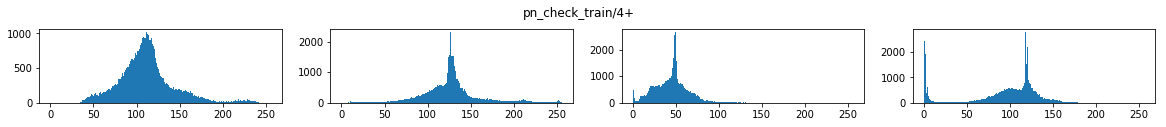

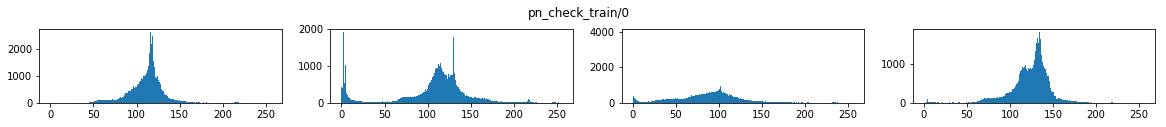

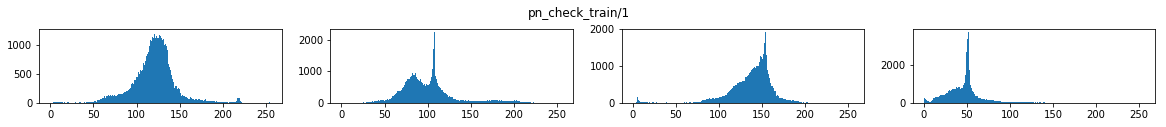

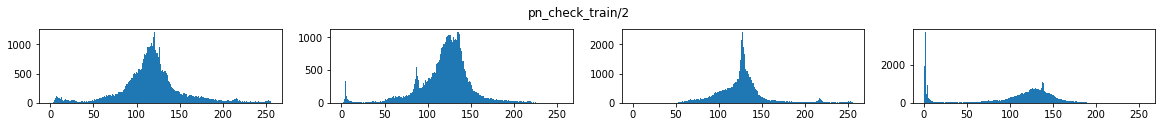

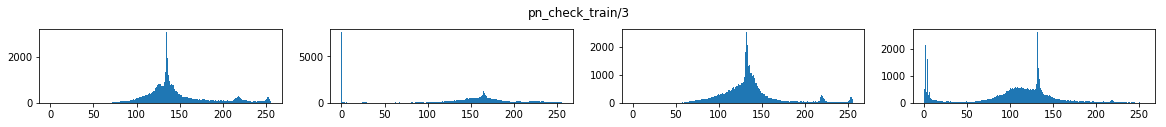

In [0]:

# Show a few histograms from each class
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(20,3))
    plt.suptitle(class_folder)
    
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(2, 4, i+1)
        img = cv2.imread(file,0)
        plt.hist(img.ravel(),256,[0,256]);
        if i > 2:
            break
    plt.show()   
    

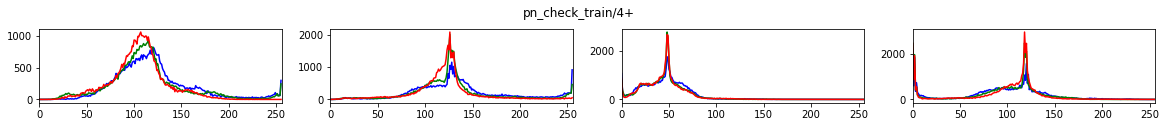

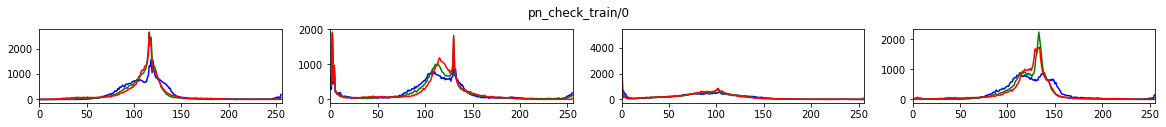

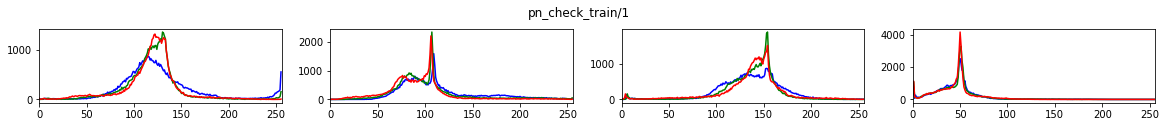

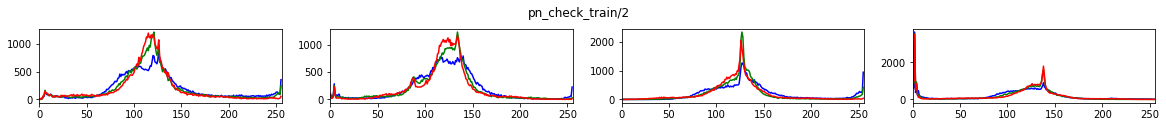

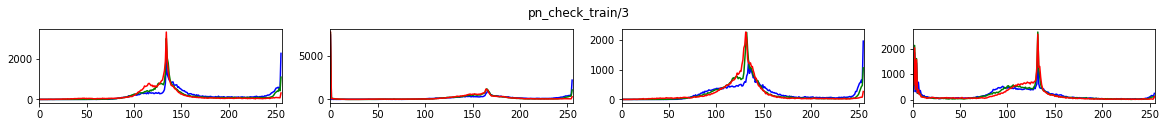

In [0]:
# Show a few RGB histograms from each class
for class_folder in glob(os.path.join(train_dir, "*")):
    plt.figure(figsize=(20,3))
    plt.suptitle(class_folder)
    color = ('b','g','r')
    
    for i, file in enumerate(glob(os.path.join(class_folder, "*.jpg"))):
        plt.subplot(2, 4, i+1)
        img = cv2.imread(file)
        
        for j,col in enumerate(color):
            histr = cv2.calcHist([img],[j],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        if i > 2:
             break
    plt.show()           

##Class Distributions
In the EDA of the sample distribution and the classes it is seen that class 2 makes up the biggest class. It is about 68 percent in both the training and validation set.  This is a very unblanaced data set and will present a large problem in the training of any model.  

In [0]:
#Import Class list and change to a pandas data frame
validation_class_distribution = pd.DataFrame(Valid_batches.classes)
train_class_distribution = pd.DataFrame(train_batches.classes)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

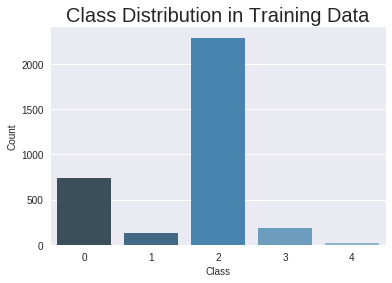

In [57]:
#Plot number of samples per class in the training set
sns.countplot(x=0, data=train_class_distribution, palette="Blues_d");
plt.title('Class Distribution in Training Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0,0.5,'Count')

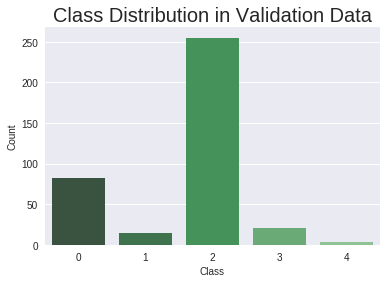

In [58]:
#Plot number of samples per class in the validation set
sns.countplot(x=0, data=validation_class_distribution, palette="Greens_d");
plt.title('Class Distribution in Validation Data', fontsize = 20)
plt.xlabel('Class', fontsize = 10)
plt.ylabel('Count', fontsize = 10)

##Definitions block for functions to be used throughout the Notebook
* Matthew correlation Metric
* precesion metric 
* recall Metric
* F1 Metric
* Plotting Confusion Matrix

In [0]:

def mcor(y_true, y_pred):
     #matthews_correlation (Coefficient used for biniary classifications if a class is imbalanced)
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
 
 
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos
 
 
    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)
 
 
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
 
 
    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
 
 
    return numerator / (denominator + K.epsilon())




def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#you can use it like this
model.compile(loss='binary_crossentropy',
              optimizer= "adam",
              metrics=[mcor,recall, f1])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##4. Initial Model
Knowing that transfer learning was to be used, it made sense to see what kind of baseline results could be achived on the dataset with a simple CNN.  As shown below the model consisted of 3 convolution layers with 1 dense layer.  A simple setup with Max pools after the activation. No normilzation was used but a dropout rate of 50% was used to control for any type of over fitting.


In [0]:
# dimensions of the images.
img_width, img_height = 224, 224
# number of samples
nb_train_samples = 3356
nb_validation_samples = 376
epochs = 5
batch_size = 16


In [59]:

#Simple Sequential CNN model

input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
__________

###4.1 Data generators to feed the data to the model
Due to resource issues and memory contraints data generators were used to augment the small data set and pass the data to the model.  There are many examples on how to use data generators which is helpful as using them creates another varible that can make analysis and predictions more complicated.  


In [85]:
# Augmentation generator that is used on the training data set:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# Augmentation genorator that is used on the test data set only a rescale is applied:
test_datagen = ImageDataGenerator(rescale=1. / 255)

#flow from directory that will call each batch
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size)

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,)

#Generator that fits the model to the data
model_history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('simple_pn.h5')

Found 3356 images belonging to 5 classes.
Found 376 images belonging to 5 classes.
Epoch 1/5
209/209 [==============================] - 88s 423ms/step - loss: 0.9696 - acc: 0.6791 - val_loss: 0.9377 - val_acc: 0.6739
Epoch 2/5
207/209 [============================>.] - ETA: 0s - loss: 0.9432 - acc: 0.6810

209/209 [==============================] - 71s 340ms/step - loss: 0.9423 - acc: 0.6822 - val_loss: 0.9358 - val_acc: 0.6739
Epoch 3/5
209/209 [==============================] - 70s 337ms/step - loss: 0.9378 - acc: 0.6796 - val_loss: 0.9335 - val_acc: 0.6739
Epoch 4/5
157/209 [=====================>........] - ETA: 16s - loss: 0.9197 - acc: 0.6907

209/209 [==============================] - 71s 341ms/step - loss: 0.9238 - acc: 0.6837 - val_loss: 0.9420 - val_acc: 0.6739
Epoch 5/5
209/209 [==============================] - 69s 331ms/step - loss: 0.9299 - acc: 0.6816 - val_loss: 0.9348 - val_acc: 0.6739


###Results of simple CNN
As the graph shows, the results of the training show poor performance.  The validation accuracy was flat and indicate there was no learning of any of the features.  This was not unexpected due to the small size of the data set.  Moving to a more complex model should improve the results.

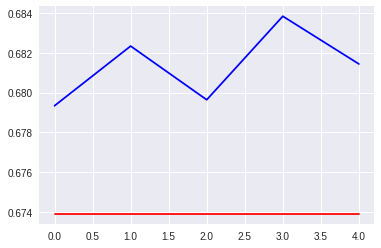

In [86]:
#Plot accuracy
plt.plot(model_history.history['acc'],'b') 
plt.plot(model_history.history['val_acc'],'r')
plt.show()

##5. Picking a model to use with Transfer Learning
###Model features
These pretrained models have been trained on extremly large data sets like the ImageNet.

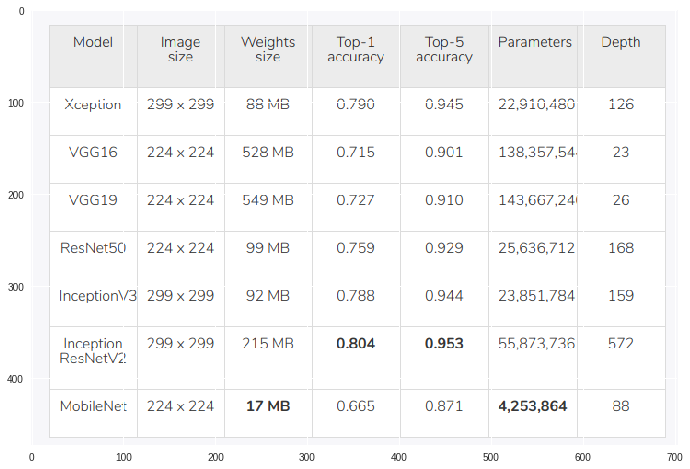

In [92]:
img = '../content/drive/practicum/Models.png'
plt.figure(figsize=(18,8))
plt.imshow(Image.open(img))


##5.1 Transfer learning using VGG19
While researching which model is best suited to the project many times the topic of medical image files being used with the VGG16 and VGG19 model came up.  Because of the nature of the image files I selected to use VGG19.  Another reason this was attractive was due to the image size requirements.  My images are already in this format.

Possible issues from looking at the model features are the weight size being much larger than any other model.  With that however the parameters are much more and can be useful with finding features small specific.





In [93]:
#initalize the VGG19 wights to a base model
VGG19base_model = VGG19(weights='imagenet',include_top = False, input_shape=(img_width, img_height, 3)) #include_top = False removes the fully connected layer and classifier. This should be removed so we can add our own.

# Add model Sequential. This will replace the final fully connected layer and classifier
VGG19add_model = Sequential()
# Flatten outputs.
VGG19add_model.add(Flatten(input_shape=VGG19base_model.output_shape[1:]))
# Add dense layer with output shape of 256.
VGG19add_model.add(Dense(256, activation='relu'))
# Add another dense layer with output shape of 5 and softmax activation function.
VGG19add_model.add(Dense(5, activation='softmax'))

80142336/80134624 [==============================] - 5s 0us/step


In [94]:
# Create full model
VGG19model = Model(inputs=VGG19base_model.input, outputs=VGG19add_model(VGG19base_model.output))
#Model summary and architeture
VGG19model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

##5.2 Selecting optimizer
There are different optimizers available. Each having their own pros and cons and can be applied to specific problems.  It is also one of the parameters that can be changed if desiered results are not being achieved.  
*   Adam
*   RMSprop
*   SGD

I used each of these at some point while training the data set looking for which one performed the best.  A good reference for what each does without being overly invloved with the math that works beind them can be found here (https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)


For use with VGG19 Adam was selected.  Typically the learning rate is lower than 0.01 but in this case it was used to see if any learning gains or losses would occur.

In [0]:
#compile model
VGG19model.compile(Adam(lr=.01), keras.losses.categorical_crossentropy, metrics=["acc"])

##5.3 Image generator difference
A different image generator setup was used in this training.  This generator has more options and different values were used.

In [101]:
from keras.preprocessing.image import ImageDataGenerator

# Create data generator from folder
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(train_dir,  target_size=(224,224), batch_size=10)
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)


/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:664: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 3356 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


In [0]:
#fit VGG19 model
model_history2 = VGG19model.fit_generator(train_gen, steps_per_epoch= 4, epochs=50, workers=16, validation_data=val_gen, validation_steps = 2, shuffle = True, verbose = 1)
VGG19model.save_weights('pn_VGG19weights.h5')

##Results of VGG19
Again the results show a validation accuracy of 60% and it does not move. After running this countless times and changing the hyperparameters there was no difference in the validation accuracy being flat.  In some instances the value would change from 5%, 25%, 30%, or 60%.  In one rare case it was at 80% but not for the full amount of epochs.  It eventlly dropped.  The results point to there being an issue with the processing of the images or possibly the data set itself.  Before investigating this further I want to try a different model and see the results.


Training accuracy is fluctating and shows no convergance and the loss is similar.  From these results not a good model.

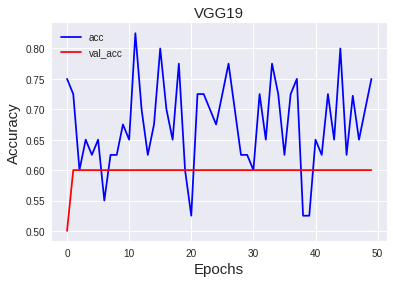

In [105]:
#Plot accuracy
plt.plot(model_history2.history['acc'],'b', label='acc') 
plt.plot(model_history2.history['val_acc'],'r', label='val_acc')
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('VGG19', fontsize = 15)
plt.legend()
plt.show()

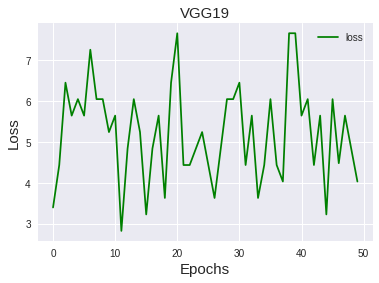

In [104]:
#Plot accuracy
plt.plot(model_history2.history['loss'], 'g', label = 'loss')
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('VGG19', fontsize = 15)
plt.legend()
plt.show()

##6. Selcting MobileNet Model
VGG19 has many parameters which means the model has learned many features that are useful in CNN image classifications.  There is an issue with is in its weights being so large which makes it application sometimes not viable.  A second approach is to use a completely different architecture which can be found in MoblieNet.  MobileNet was designed with the idea of being easy to use in many applications because the size of the parameters is comparatively low.  Its a light weight classifier but because of this the amount of learning that the network can achieve is relatively high. Mobile net has 88 layers but is very low on the resource consumption.


###Added comment:

After running the images with the MobileNet, similar issues occurred as was present in the VGG19 model.  In this case there was even less accuracy.  I reached out to my colleges that were happy enough to hand over a pile of data and ask if they had similar issues.  They had been working on something entirely different but had been working with similar photos just from differing time points.  Due to this they had model weights that they saved and were willing to share with me.  

There should be some effect of using pre-trained weights on a similar data set that was much larger than my own.  They had also used MobileNet.

Another difference in use for the MobileNet setup compared to the set up for VGG19 is that Keras functional API was used to construct the model.  This made the transfer learning of the MobileNet much easier to follow as well as implement.

In [110]:
from keras.preprocessing.image import ImageDataGenerator

# Create data generator from folder
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

val_datagen = ImageDataGenerator()

# Create model and load weights. Using Keras API and not sequential method. 
# Exluded the final connected layers and used own by excluding the top
mobile = keras.applications.mobilenet.MobileNet(
    input_shape=(224, 224, 3), alpha=0.5, include_top=False)
mobile.load_weights("../content/drive/practicum/mobilenet_224_64_14_2018_03_09.h5")

# Flatten output
flatten = keras.layers.Flatten()(mobile.output)
# Predict PN
pn_prediction = keras.layers.Dense(5, activation="softmax")(flatten)
# Create model with image as input and prediction as output
mobile_model = keras.models.Model(mobile.input, pn_prediction)




/usr/local/lib/python3.6/dist-packages/keras/preprocessing/image.py:664: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


### Summary shows the entire Architecture used for MobileNet

In [111]:
mobile_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 16)      432       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 16)      64        
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 16)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 16)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 16)      144       
__________

###Freeze Layers
Some of the weights that were trained on Imagenet will be useful to our problem and because of that some of the layers will be frozen to keep them from being updated with each iteration.

In [0]:
#Freeze layers except last 
for layer in mobile_model.layers[:-23]:
    layer.trainable=False

In [0]:
#compile model
mobile_model.compile(Adam(lr=.001), keras.losses.categorical_crossentropy, metrics=["acc"])

In [114]:
# Fit the model on the batches generated by datagen.flow().
#lr = keras.callbacks.ReduceLROnPlateau()
train_gen = train_datagen.flow_from_directory(train_dir,  target_size=(224,224), batch_size=10)
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)


Found 3356 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


In [0]:
#https://github.com/keras-team/keras/issues/6499 (prediction and evaluation generator post)

### Number of Epochs

Because MobileNet is lightweight, the number of epochs that can be run over a small amount of time can be increased and can show convergence possible better in the case of this data set.

In [119]:
#Fit model and save weights
#mobile_model.fit_generator(train_gen, epochs=2, workers=16, callbacks=[lr], validation_data=val_gen)# used if wanting to use funtion of lowering the learning rate if the accuracy plateaus
mobile_history = mobile_model.fit_generator(train_gen, steps_per_epoch= 18, epochs=150, workers=16, validation_data=val_gen, validation_steps = 3,shuffle = True, verbose = 1)
mobile_model.save_weights('pn_moible_no_top.h5')

Epoch 1/150
18/18 [==============================] - 6s 332ms/step - loss: 0.8692 - acc: 0.6444 - val_loss: 1.0524 - val_acc: 0.7000
Epoch 2/150
18/18 [==============================] - 4s 206ms/step - loss: 0.7969 - acc: 0.7778 - val_loss: 1.0591 - val_acc: 0.6667
Epoch 3/150
18/18 [==============================] - 4s 203ms/step - loss: 0.6085 - acc: 0.8500 - val_loss: 1.0873 - val_acc: 0.6667
Epoch 4/150
18/18 [==============================] - 4s 206ms/step - loss: 0.5369 - acc: 0.8389 - val_loss: 1.1144 - val_acc: 0.6667
Epoch 5/150
18/18 [==============================] - 4s 208ms/step - loss: 0.5313 - acc: 0.8667 - val_loss: 1.1319 - val_acc: 0.6667
Epoch 6/150
18/18 [==============================] - 4s 206ms/step - loss: 0.5668 - acc: 0.8111 - val_loss: 1.1393 - val_acc: 0.6667
Epoch 135/150
18/18 [==============================] - 4s 203ms/step - loss: 0.3846 - acc: 0.9056 - val_loss: 1.3612 - val_acc: 0.6333
Epoch 136/150
18/18 [==============================] - 4s 203ms/ste

18/18 [==============================] - 4s 203ms/step - loss: 0.5529 - acc: 0.8333 - val_loss: 1.5358 - val_acc: 0.5000
Epoch 143/150
18/18 [==============================] - 4s 206ms/step - loss: 0.4866 - acc: 0.8778 - val_loss: 1.6092 - val_acc: 0.4333
Epoch 144/150
18/18 [==============================] - 4s 203ms/step - loss: 0.5038 - acc: 0.8722 - val_loss: 1.5129 - val_acc: 0.5333
Epoch 145/150
18/18 [==============================] - 3s 187ms/step - loss: 0.5077 - acc: 0.8443 - val_loss: 1.5588 - val_acc: 0.4333
Epoch 146/150
18/18 [==============================] - 5s 265ms/step - loss: 0.5575 - acc: 0.8500 - val_loss: 1.5757 - val_acc: 0.4667
Epoch 147/150
18/18 [==============================] - 4s 201ms/step - loss: 0.5130 - acc: 0.8389 - val_loss: 1.6176 - val_acc: 0.5000
Epoch 148/150
18/18 [==============================] - 4s 200ms/step - loss: 0.5019 - acc: 0.8278 - val_loss: 1.5186 - val_acc: 0.5000
Epoch 149/150
18/18 [==============================] - 3s 167ms/step 

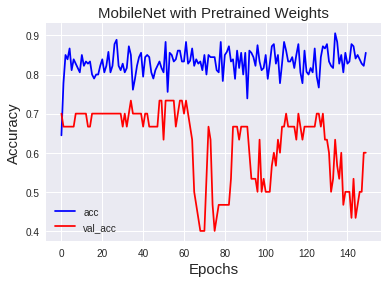

In [120]:
#Plot accuracy
plt.plot(mobile_history.history['acc'],'b', label='acc') 
plt.plot(mobile_history.history['val_acc'],'r', label='val_acc')
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('MobileNet with Pretrained Weights', fontsize = 15)
plt.legend()
plt.show()

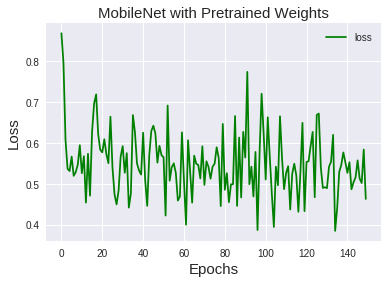

In [121]:
#Plot loss
plt.plot(mobile_history.history['loss'], 'g', label = 'loss')
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('MobileNet with Pretrained Weights', fontsize = 15)
plt.legend()
plt.show()

##MobileNet results
Not unlike the VGG19 resutls the validation accuracy was again flat and didn't train very well.  Up to this point only the optimizer Adam has been used.  To see if a different optimizer can be more effective the next block runs the same mobile net but with SGD and finally RMSprop.

##7. Use of Different Optimizers


*   Adam - with different hyper parameters
*   SGD
*   RMSprop

In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Create data generator from folder
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

val_datagen = ImageDataGenerator()

# Create model and load weights. Using Keras API and not sequential method. 
# Exluded the final connected layers and used own by excluding the top
mobile = keras.applications.mobilenet.MobileNet()
#mobile.load_weights("../content/drive/practicum/mobilenet_224_64_14_2018_03_09.h5")

x = mobile.layers[-6].output

# Predict PN
pn_prediction = keras.layers.Dense(5, activation="softmax")(x)

# Create model with image as input and prediction as output
opt_model = keras.models.Model(mobile.input, pn_prediction)
opt_model.summary()


In [0]:
#Freeze layers except last 32
for layer in opt_model.layers[:-32]:
    layer.trainable=False

In [0]:
#compile model
#opt_model.compile(Adam(lr=.0001), keras.losses.categorical_crossentropy, metrics=["acc"])
#opt_model.compile(SGD(lr=.001, momentum=.9), keras.losses.categorical_crossentropy,metrics=['acc'])
opt_model.compile(RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0), keras.losses.categorical_crossentropy,metrics=['acc'])


In [232]:
# Fit the model on the batches generated by datagen.flow().
#lr = keras.callbacks.ReduceLROnPlateau()
train_gen = train_datagen.flow_from_directory(train_dir,  target_size=(224,224), batch_size=10)
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)


Found 3356 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


In [233]:
#opt_history = opt_model.fit_generator(train_gen, steps_per_epoch= 32, epochs=100, workers=16, callbacks=[lr],validation_data=val_gen, validation_steps = 3, shuffle = True, verbose = 1)
opt_history = opt_model.fit_generator(train_gen, steps_per_epoch= 32, epochs=100, workers=16, validation_data=val_gen, validation_steps = 3, shuffle = True, verbose = 1)
opt_model.save_weights('pn_moibleExtracted.h5')

Epoch 1/100
32/32 [==============================] - 28s 877ms/step - loss: 1.4507 - acc: 0.6781 - val_loss: 4.5626 - val_acc: 0.3333
Epoch 2/100
32/32 [==============================] - 7s 229ms/step - loss: 1.0371 - acc: 0.7156 - val_loss: 2.2541 - val_acc: 0.3333
Epoch 3/100
32/32 [==============================] - 7s 222ms/step - loss: 1.1119 - acc: 0.6875 - val_loss: 4.8571 - val_acc: 0.3333
Epoch 4/100
32/32 [==============================] - 7s 227ms/step - loss: 0.9489 - acc: 0.6906 - val_loss: 6.5023 - val_acc: 0.3333
Epoch 5/100
32/32 [==============================] - 9s 275ms/step - loss: 0.9321 - acc: 0.7115 - val_loss: 9.7822 - val_acc: 0.3333
Epoch 6/100
32/32 [==============================] - 7s 208ms/step - loss: 0.3461 - acc: 0.8937 - val_loss: 1.2341 - val_acc: 0.3333
Epoch 78/100
32/32 [==============================] - 7s 229ms/step - loss: 0.4152 - acc: 0.8719 - val_loss: 0.9989 - val_acc: 0.3667
Epoch 79/100
22/32 [===================>..........] - ETA: 1s - los

32/32 [==============================] - 8s 241ms/step - loss: 0.5676 - acc: 0.8219 - val_loss: 1.0762 - val_acc: 0.3333
Epoch 80/100
32/32 [==============================] - 8s 258ms/step - loss: 0.4537 - acc: 0.8500 - val_loss: 1.2386 - val_acc: 0.3333
Epoch 81/100
32/32 [==============================] - 8s 246ms/step - loss: 0.4344 - acc: 0.8594 - val_loss: 2.3065 - val_acc: 0.3333
Epoch 82/100
32/32 [==============================] - 8s 239ms/step - loss: 0.5172 - acc: 0.8250 - val_loss: 3.8245 - val_acc: 0.3333
Epoch 83/100
32/32 [==============================] - 8s 244ms/step - loss: 0.4406 - acc: 0.8687 - val_loss: 2.7900 - val_acc: 0.3333
Epoch 84/100
32/32 [==============================] - 8s 236ms/step - loss: 0.5319 - acc: 0.8375 - val_loss: 4.5353 - val_acc: 0.3333
Epoch 85/100
19/32 [================>.............] - ETA: 2s - loss: 0.4503 - acc: 0.8421

32/32 [==============================] - 8s 250ms/step - loss: 0.4250 - acc: 0.8594 - val_loss: 3.7337 - val_acc: 0.3333
Epoch 86/100
32/32 [==============================] - 8s 240ms/step - loss: 0.4922 - acc: 0.8406 - val_loss: 2.4231 - val_acc: 0.3333
Epoch 87/100
32/32 [==============================] - 8s 240ms/step - loss: 0.4856 - acc: 0.8406 - val_loss: 1.8959 - val_acc: 0.3333
Epoch 88/100
32/32 [==============================] - 8s 266ms/step - loss: 0.4481 - acc: 0.8625 - val_loss: 1.5779 - val_acc: 0.3333
Epoch 89/100
32/32 [==============================] - 7s 232ms/step - loss: 0.3930 - acc: 0.8719 - val_loss: 1.6335 - val_acc: 0.3333
Epoch 90/100
32/32 [==============================] - 7s 222ms/step - loss: 0.4686 - acc: 0.8594 - val_loss: 3.7016 - val_acc: 0.3333
Epoch 91/100
22/32 [===================>..........] - ETA: 1s - loss: 0.4600 - acc: 0.8455

32/32 [==============================] - 7s 215ms/step - loss: 0.4268 - acc: 0.8562 - val_loss: 2.0491 - val_acc: 0.3333
Epoch 92/100
32/32 [==============================] - 7s 208ms/step - loss: 0.5416 - acc: 0.8490 - val_loss: 4.5419 - val_acc: 0.3333
Epoch 93/100
32/32 [==============================] - 7s 214ms/step - loss: 0.3733 - acc: 0.8750 - val_loss: 4.5364 - val_acc: 0.3333
Epoch 94/100
32/32 [==============================] - 7s 210ms/step - loss: 0.3866 - acc: 0.8812 - val_loss: 4.1017 - val_acc: 0.3333
Epoch 95/100
32/32 [==============================] - 7s 212ms/step - loss: 0.4849 - acc: 0.8094 - val_loss: 2.0895 - val_acc: 0.3333
Epoch 96/100
32/32 [==============================] - 7s 227ms/step - loss: 0.4195 - acc: 0.8406 - val_loss: 1.6810 - val_acc: 0.3333
Epoch 97/100
22/32 [===================>..........] - ETA: 1s - loss: 0.4910 - acc: 0.8682

32/32 [==============================] - 7s 208ms/step - loss: 0.4812 - acc: 0.8531 - val_loss: 1.2743 - val_acc: 0.3000
Epoch 98/100
32/32 [==============================] - 7s 227ms/step - loss: 0.3075 - acc: 0.8968 - val_loss: 1.1440 - val_acc: 0.3333
Epoch 99/100
32/32 [==============================] - 8s 243ms/step - loss: 0.4402 - acc: 0.8375 - val_loss: 1.5411 - val_acc: 0.3333
Epoch 100/100
32/32 [==============================] - 8s 245ms/step - loss: 0.4124 - acc: 0.8594 - val_loss: 1.2834 - val_acc: 0.3000


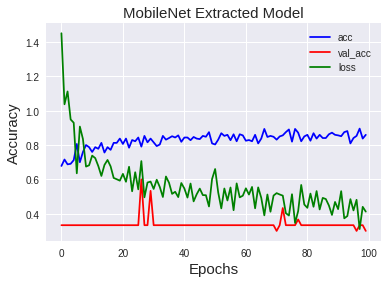

In [234]:
#Plot accuracy
plt.plot(opt_history.history['acc'],'b', label='acc') 
plt.plot(opt_history.history['val_acc'],'r', label='val_acc')
plt.plot(opt_history.history['loss'], 'g', label = 'loss')
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('MobileNet Extracted Model', fontsize = 15)
plt.legend()
plt.show()

##Results of Different Optimizers

The results of using Adam with differing hyper-parameter didn’t change past results.  They were not saved as they didn't show anything new and the use of SGD also did not change the results seen previously.  RMSprop however yielded a different result.  As seen in the graph above there was no change in the validation accuracy and was not good at about 30% for the entire 100 epochs.  The metrics of interest at this point are found in the loss and the training accuracy.  To this point that has not been any stabilization and there has been no drop in the loss function.  

With the loss function steadily decreasing over each epoch the model was learning, it just was not shown in the validation accuracy.

##8. Main Issue with the Data Set
The biggest issue that can be seen is that there is no learning or measureable results from the validation accuracy.  To address this the data was examined again.  Refereing back to the bar charts shown before, there was more samples that made up about 68% of the data set in class 2.  This is likely the issue and can be checked using a confusion matrix about some of the predictions that are being made by the model. 

There are a couple ways to address an imbalanced data set.
*   Get more data
*   Add weights to each class
*   Create synthetic data
*   Augment all under represented classes until data is more balanced
*   Oversample the minority/ Undersample the majority




##9. Bring some ideas together


*   Use MobileNet with company weights
*   Add weights to the classes
*   Use RMSprop



##10. Find class weights

In [122]:
#define fuction to find weights of classes 
#Found defined function at https://github.com/keras-team/keras/issues/5116 by cbaziotis in the comments
def get_class_weights(y, smooth_factor=.1):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

#train_batches and validation_bathes found in next Flow from directory block from image generator.
class_weights = get_class_weights(train_batches.classes) 
class_weights

#Run if not running get_class_weights. get_class_wights not needed once calculated.
class_weights = {0: 2.61676024121439, 1: 6.956329463792151, 2: 1.0, 3: 6.096899224806202, 4: 10.197730956239871}
class_weights

{0: 2.61676024121439,
 1: 6.956329463792151,
 2: 1.0,
 3: 6.096899224806202,
 4: 10.197730956239871}

In [154]:
from keras.preprocessing.image import ImageDataGenerator

# Create data generator from folder
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=25,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

val_datagen = ImageDataGenerator(rescale=1. / 255)

# Create model and load weights. Using Keras API and not sequential method. 
# Exluded the final connected layers and used own by excluding the top
mobile = keras.applications.mobilenet.MobileNet()

#mobile.load_weights("../content/drive/practicum/mobilenet_224_64_14_2018_03_09.h5") #cannot load weights. There is a difference in the layers and is no longer compatible
#mobile.load_weights("../content/drive/practicum/pn_moibleExtracted.h5")
x = mobile.layers[-6].output

# Predict PN
pn_prediction = keras.layers.Dense(5, activation="softmax")(x)

# Create model with image as input and prediction as output
F_model = keras.models.Model(mobile.input, pn_prediction)
F_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

In [0]:
#Freeze layers except last 32
for layer in F_model.layers[:-32]:
    layer.trainable=False

In [0]:
#compile model
#F_model.compile(Adam(lr=.0001), keras.losses.categorical_crossentropy, metrics=["acc"])
#F_model.compile(SGD(lr=.001, momentum=.9), keras.losses.categorical_crossentropy,metrics=['acc'])
F_model.compile(RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0), keras.losses.categorical_crossentropy,metrics=['acc'])


In [147]:
# Fit the model on the batches generated by datagen.flow().
#lr = keras.callbacks.ReduceLROnPlateau()
train_gen = train_datagen.flow_from_directory(train_dir,  target_size=(224,224), batch_size=10)
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224,224), batch_size=10)


Found 3356 images belonging to 5 classes.
Found 376 images belonging to 5 classes.


In [148]:
#F_history = F_model.fit_generator(train_gen, steps_per_epoch= 32, epochs=100, workers=16, callbacks=[lr],validation_data=val_gen, validation_steps = 3, shuffle = True, verbose = 1)
F_history = F_model.fit_generator(train_gen, steps_per_epoch= 32, epochs=200, workers=16, validation_data=val_gen, validation_steps = 3, class_weight = class_weights, shuffle = True, verbose = 1)
F_model.save_weights('pn_mobileF.h5')

Epoch 1/200
32/32 [==============================] - 13s 412ms/step - loss: 3.2561 - acc: 0.4594 - val_loss: 1.2860 - val_acc: 0.4333
Epoch 2/200
32/32 [==============================] - 6s 175ms/step - loss: 2.7909 - acc: 0.5344 - val_loss: 1.4373 - val_acc: 0.3667
Epoch 3/200
32/32 [==============================] - 6s 184ms/step - loss: 2.2103 - acc: 0.5719 - val_loss: 1.3332 - val_acc: 0.4667
Epoch 4/200
32/32 [==============================] - 6s 185ms/step - loss: 2.0621 - acc: 0.6583 - val_loss: 1.2952 - val_acc: 0.4333
Epoch 5/200
32/32 [==============================] - 6s 180ms/step - loss: 2.2061 - acc: 0.6563 - val_loss: 0.8452 - val_acc: 0.6333
Epoch 6/200
32/32 [==============================] - 6s 179ms/step - loss: 2.4534 - acc: 0.6375 - val_loss: 1.8384 - val_acc: 0.1000
Epoch 7/200
20/32 [=================>............] - ETA: 1s - loss: 3.0409 - acc: 0.6100

32/32 [==============================] - 6s 178ms/step - loss: 3.1324 - acc: 0.6125 - val_loss: 2.3919 - val_acc: 0.0667
Epoch 8/200
32/32 [==============================] - 6s 185ms/step - loss: 2.5813 - acc: 0.5656 - val_loss: 1.8079 - val_acc: 0.3000
Epoch 9/200
32/32 [==============================] - 6s 181ms/step - loss: 2.1468 - acc: 0.6250 - val_loss: 2.2036 - val_acc: 0.2000
Epoch 10/200
32/32 [==============================] - 8s 240ms/step - loss: 2.8208 - acc: 0.5875 - val_loss: 2.3386 - val_acc: 0.0667
Epoch 11/200
32/32 [==============================] - 6s 186ms/step - loss: 1.8988 - acc: 0.6594 - val_loss: 3.5005 - val_acc: 0.0333
Epoch 12/200
32/32 [==============================] - 6s 182ms/step - loss: 1.8022 - acc: 0.7312 - val_loss: 1.6947 - val_acc: 0.3000
Epoch 13/200
25/32 [======================>.......] - ETA: 0s - loss: 1.8461 - acc: 0.7040

32/32 [==============================] - 6s 179ms/step - loss: 1.9502 - acc: 0.7062 - val_loss: 1.3343 - val_acc: 0.4333
Epoch 14/200
32/32 [==============================] - 6s 182ms/step - loss: 2.3626 - acc: 0.6063 - val_loss: 2.3302 - val_acc: 0.1667
Epoch 15/200
32/32 [==============================] - 6s 177ms/step - loss: 2.5094 - acc: 0.5750 - val_loss: 1.7702 - val_acc: 0.2333
Epoch 16/200
32/32 [==============================] - 6s 178ms/step - loss: 2.2786 - acc: 0.6208 - val_loss: 1.3260 - val_acc: 0.3667
Epoch 17/200
32/32 [==============================] - 6s 176ms/step - loss: 2.2738 - acc: 0.6156 - val_loss: 1.2486 - val_acc: 0.4000
Epoch 18/200
32/32 [==============================] - 6s 187ms/step - loss: 2.1308 - acc: 0.6625 - val_loss: 2.5328 - val_acc: 0.1667
Epoch 19/200
25/32 [======================>.......] - ETA: 0s - loss: 1.9891 - acc: 0.6440

32/32 [==============================] - 6s 181ms/step - loss: 1.9372 - acc: 0.6406 - val_loss: 2.5117 - val_acc: 0.1667
Epoch 20/200
32/32 [==============================] - 6s 203ms/step - loss: 2.1674 - acc: 0.6719 - val_loss: 2.2590 - val_acc: 0.2333
Epoch 21/200
32/32 [==============================] - 6s 179ms/step - loss: 2.3686 - acc: 0.6281 - val_loss: 1.8130 - val_acc: 0.3333
Epoch 22/200
32/32 [==============================] - 6s 187ms/step - loss: 1.8025 - acc: 0.6656 - val_loss: 2.0068 - val_acc: 0.2667
Epoch 23/200
32/32 [==============================] - 6s 179ms/step - loss: 1.7016 - acc: 0.6344 - val_loss: 1.5232 - val_acc: 0.3667
Epoch 24/200
32/32 [==============================] - 6s 180ms/step - loss: 1.6343 - acc: 0.6656 - val_loss: 2.5903 - val_acc: 0.1000
Epoch 25/200
24/32 [=====================>........] - ETA: 1s - loss: 2.0859 - acc: 0.6958

32/32 [==============================] - 6s 185ms/step - loss: 1.9834 - acc: 0.6938 - val_loss: 2.4477 - val_acc: 0.1000
Epoch 26/200
32/32 [==============================] - 6s 179ms/step - loss: 1.7796 - acc: 0.6938 - val_loss: 2.5091 - val_acc: 0.1000
Epoch 27/200
32/32 [==============================] - 6s 175ms/step - loss: 1.9418 - acc: 0.7219 - val_loss: 2.2048 - val_acc: 0.1000
Epoch 28/200
32/32 [==============================] - 6s 187ms/step - loss: 1.6863 - acc: 0.7063 - val_loss: 2.6539 - val_acc: 0.0333
Epoch 29/200
32/32 [==============================] - 6s 173ms/step - loss: 1.8454 - acc: 0.7094 - val_loss: 3.6736 - val_acc: 0.0333
Epoch 30/200
32/32 [==============================] - 7s 214ms/step - loss: 2.5056 - acc: 0.5813 - val_loss: 3.0418 - val_acc: 0.0333
Epoch 31/200
23/32 [====================>.........] - ETA: 1s - loss: 1.6410 - acc: 0.6130

32/32 [==============================] - 6s 174ms/step - loss: 1.8258 - acc: 0.6188 - val_loss: 4.4442 - val_acc: 0.0333
Epoch 32/200
32/32 [==============================] - 6s 189ms/step - loss: 1.6413 - acc: 0.6406 - val_loss: 5.4815 - val_acc: 0.0333
Epoch 33/200
32/32 [==============================] - 6s 176ms/step - loss: 1.9093 - acc: 0.6906 - val_loss: 4.4212 - val_acc: 0.0333
Epoch 34/200
32/32 [==============================] - 6s 186ms/step - loss: 1.8006 - acc: 0.6406 - val_loss: 2.5953 - val_acc: 0.1333
Epoch 35/200
32/32 [==============================] - 6s 180ms/step - loss: 1.6886 - acc: 0.6969 - val_loss: 3.4762 - val_acc: 0.0333
Epoch 36/200
32/32 [==============================] - 6s 184ms/step - loss: 1.7330 - acc: 0.7281 - val_loss: 2.0787 - val_acc: 0.2667
Epoch 37/200
24/32 [=====================>........] - ETA: 1s - loss: 1.5550 - acc: 0.6833

32/32 [==============================] - 6s 179ms/step - loss: 1.3901 - acc: 0.7156 - val_loss: 2.1339 - val_acc: 0.2333
Epoch 38/200
32/32 [==============================] - 6s 182ms/step - loss: 2.1093 - acc: 0.6594 - val_loss: 1.9187 - val_acc: 0.2333
Epoch 39/200
32/32 [==============================] - 6s 178ms/step - loss: 1.6126 - acc: 0.6574 - val_loss: 2.6549 - val_acc: 0.1333
Epoch 40/200
32/32 [==============================] - 7s 211ms/step - loss: 2.1306 - acc: 0.6938 - val_loss: 3.1980 - val_acc: 0.0667
Epoch 41/200
32/32 [==============================] - 6s 175ms/step - loss: 1.8770 - acc: 0.6563 - val_loss: 2.6162 - val_acc: 0.1333
Epoch 42/200
32/32 [==============================] - 6s 183ms/step - loss: 1.9563 - acc: 0.6906 - val_loss: 4.0240 - val_acc: 0.0333
Epoch 43/200
23/32 [====================>.........] - ETA: 1s - loss: 1.3566 - acc: 0.7217

32/32 [==============================] - 6s 180ms/step - loss: 1.4383 - acc: 0.7219 - val_loss: 3.1624 - val_acc: 0.0667
Epoch 44/200
32/32 [==============================] - 6s 179ms/step - loss: 1.4608 - acc: 0.7531 - val_loss: 4.1400 - val_acc: 0.0333
Epoch 45/200
32/32 [==============================] - 6s 184ms/step - loss: 1.7171 - acc: 0.7156 - val_loss: 3.0053 - val_acc: 0.0667
Epoch 46/200
32/32 [==============================] - 6s 178ms/step - loss: 1.9998 - acc: 0.6344 - val_loss: 2.9208 - val_acc: 0.0667
Epoch 47/200
32/32 [==============================] - 6s 187ms/step - loss: 1.5027 - acc: 0.7250 - val_loss: 3.7524 - val_acc: 0.0667
Epoch 48/200
32/32 [==============================] - 6s 174ms/step - loss: 1.8562 - acc: 0.6844 - val_loss: 2.3542 - val_acc: 0.1000
Epoch 49/200
32/32 [==============================] - 6s 184ms/step - loss: 0.7678 - acc: 0.8375 - val_loss: 5.1019 - val_acc: 0.0333
Epoch 183/200
32/32 [==============================] - 6s 188ms/step - loss

32/32 [==============================] - 6s 188ms/step - loss: 0.5884 - acc: 0.8562 - val_loss: 4.6458 - val_acc: 0.0667
Epoch 188/200
32/32 [==============================] - 7s 214ms/step - loss: 0.8164 - acc: 0.8687 - val_loss: 4.1682 - val_acc: 0.1667
Epoch 189/200
32/32 [==============================] - 6s 186ms/step - loss: 0.9315 - acc: 0.8531 - val_loss: 5.3830 - val_acc: 0.0333
Epoch 190/200
32/32 [==============================] - 6s 191ms/step - loss: 0.7971 - acc: 0.8219 - val_loss: 4.3907 - val_acc: 0.0333
Epoch 191/200
32/32 [==============================] - 6s 186ms/step - loss: 0.5875 - acc: 0.8844 - val_loss: 3.5225 - val_acc: 0.0667
Epoch 192/200
32/32 [==============================] - 6s 191ms/step - loss: 0.9333 - acc: 0.8531 - val_loss: 2.8291 - val_acc: 0.2000
Epoch 193/200
23/32 [====================>.........]

32/32 [==============================] - 6s 187ms/step - loss: 0.4578 - acc: 0.8844 - val_loss: 4.6457 - val_acc: 0.0667
Epoch 194/200
32/32 [==============================] - 6s 188ms/step - loss: 0.8582 - acc: 0.8376 - val_loss: 3.9645 - val_acc: 0.0667
Epoch 195/200
32/32 [==============================] - 6s 191ms/step - loss: 0.6776 - acc: 0.8625 - val_loss: 3.7471 - val_acc: 0.1333
Epoch 196/200
32/32 [==============================] - 6s 194ms/step - loss: 0.8979 - acc: 0.8437 - val_loss: 5.0465 - val_acc: 0.0333
Epoch 197/200
32/32 [==============================] - 6s 188ms/step - loss: 0.8461 - acc: 0.8406 - val_loss: 4.4804 - val_acc: 0.0667
Epoch 198/200
32/32 [==============================] - 8s 236ms/step - loss: 0.7667 - acc: 0.8312 - val_loss: 5.4454 - val_acc: 0.0333
Epoch 199/200
24/32 [=====================>........] - ETA: 1s - loss: 0.8770 - acc: 0.8458

32/32 [==============================] - 6s 186ms/step - loss: 0.9475 - acc: 0.8312 - val_loss: 5.1276 - val_acc: 0.0333
Epoch 200/200
32/32 [==============================] - 6s 187ms/step - loss: 0.8042 - acc: 0.8281 - val_loss: 5.7321 - val_acc: 0.0333


In [0]:
F_model.save_weights('/content/drive/practicum/pn_mobileF.h5')

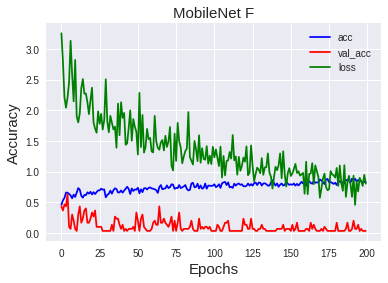

In [149]:
#Plot accuracy
plt.plot(F_history.history['acc'],'b', label='acc') 
plt.plot(F_history.history['val_acc'],'r', label='val_acc')
plt.plot(F_history.history['loss'], 'g', label = 'loss')
plt.ylabel('Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 15)
plt.title('MobileNet F', fontsize = 15)
plt.legend()
plt.show()

##10. Results of the Final methods in MobileNet
The loss rate was not as stable and did not decrease like it did from the first attempt using the RMSprop optimizer.  The validation accuracy was again realativly flat and the training accuracy was only slightly better.  The question is what is causing this issue.

##11. Change to flow from directory and image generator
A different image generator setup was used in this training. It was spefically used so that the images were preprocced the same way images from Imagenet were processed for use in mobile net.

##Train/Validation batches 
Used to show what predicitons are occuring within a confusion matrix.  Due to the imbalanced classes the the predictions are scewed to one class only. When this happens it shows the reason the validation accuracy is flat lined and depending on the class it only shows accuracy to about 70 percent maximum which would be the largest class 2.

In [0]:
#image generator, mobilenet preprocessing and flow from directory.
train_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    train_dir,  target_size=(224,224), batch_size=10)
Valid_batches = ImageDataGenerator(preprocessing_function=keras.applications.mobilenet.preprocess_input).flow_from_directory(
    val_dir, target_size=(224,224), batch_size=10, shuffle = True)
model_history2 = model.fit_generator(train_batches, steps_per_epoch= 4, epochs=50, workers=16, validation_data=Valid_batches, validation_steps = 2, class_weight = class_weights ,shuffle = True, verbose = 1)

In [27]:
#create array list of the classes in the validation batch
valid_labels = Valid_batches.classes
valid_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [212]:
#bringing up the validation folder names
Valid_batches.class_indices

{'PN_0': 0, 'PN_1': 1, 'PN_2': 2, 'PN_3': 3, 'PN_4+': 4}

In [0]:
#To create the predicition model using the validation samples. NOTE: steps must be the sample divided by the number of batch size. In this case it was 10.
#This is needed to create a correct confusion matrix.
predictions = model.predict_generator(Valid_batches, steps = 37.6,verbose = 0)

In [214]:
predictions

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
#The confusion matrix is made from the labels provided and passed to the argument. 
#arg max is selected to take the maximum value of the prediction.
cm = confusion_matrix(valid_labels, predictions.argmax(axis = 1))

Confusion matrix, without normalization
[[  0   0   0  82   0]
 [  0   0   0  15   0]
 [  0   0   0 255   0]
 [  0   0   0  21   0]
 [  0   0   0   3   0]]


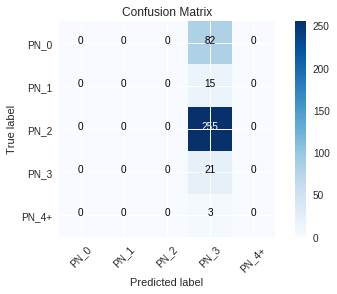

In [216]:
#plot_confusion_matrix is defined elsewhere but was retireved from SciKitLearn 
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
cm_plot_labels = ['PN_0','PN_1','PN_2','PN_3','PN_4+']
plot_confusion_matrix(cm, cm_plot_labels,title = 'Confusion Matrix')

##12. Summary

Results from all models show that dealing with an imbalanced data set can be challenging and the desired learning rate or accuracy is difficult to achieve.  There are methods that have been developed to address imbalanced data.  What makes this more challenging is the small data set size.  If more images are collected then there is a possibility that better results can be achieved.  The issue of may still exist with more added sample because class 2 is biologically more normal and occurs much more frequently in real world cases.  

All the best methods undertaken in this project were combined but the results still showed poor accuracy. Moving forward there are some ideas that can be attempted with this data set.  
* One of the biggest is augmentation of images to balance the data set. 
* Ensemble models can be attempted to find better average results.
* Different metrics can be used to access the models like ROC curves, F scores, Precision.
* Create synthetic data.
* Try a different algorithm

This project was difficult to proceed through but was a great learning tool in understanding the limits of certain methods as well as showing levels of competency within python and convolution neural networks.

In [0]:
#Current versions
keras.__version__
print (sys.version)
print(tf.__version__)

3.6.5 (default, Apr  1 2018, 05:46:30) 
[GCC 7.3.0]
1.5.0


#Resources
ImageNet: VGGNet, ResNet, Inception, and Xception with Keras

https://www.pyimagesearch.com/2017/03/20/imagenet-vggnet-resnet-inception-xception-keras/

Nearly every page in Keras

https://keras.io/applications/

MobileNetV2

https://github.com/xiaochus/MobileNetV2/blob/master/train.py

Class weights function

https://github.com/keras-team/keras/issues/5116

Plots

https://seaborn.pydata.org/tutorial/categorical.html

Imbalanced Data

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

MobileNet and confusion matrix

http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

https://www.youtube.com/channel/UC4UJ26WkceqONNF5S26OiVw

Transfer Learning

https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

VGG16 methods

https://www.kaggle.com/fujisan/use-keras-pre-trained-vgg16-acc-98

Histograms

https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_histogram_begins/py_histogram_begins.html

Image Normilization

https://stackoverflow.com/questions/38025838/normalizing-images-in-opencv

Learning rates

https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

